In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import itertools
from resources.tokTT import CommentTokenizer as CT
from resources.basicIO import InputOutput as IO
from resources.filterLang import FilterLanguage as FL
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.base import BaseEstimator, TransformerMixin
import fasttext
from scipy import spatial
from scipy.spatial import distance
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import SGDClassifier
#from sklearn.linear_model import LassoLars
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
import copy
import scipy
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.model_selection import validation_curve
from sklearn.linear_model import Ridge


### Load Fasttext Unsupervised Model

In [54]:
model_2 = fasttext.load_model("models/ft_unsupervised_N_2.bin")
model_3 = fasttext.load_model("models/ft_unsupervised_N_3.bin")


### Load Dataset

In [86]:
df_sample = pd.read_csv("datasets/random_sample_data.csv")
# remove unnecessary comments
df_sample = df_sample.drop([x for x in range(len(df_sample)) if int(
    df_sample['label'][x]) != 0 and int(df_sample['label'][x]) != 1])

df_sample['label'].value_counts()


0    1846
1    1408
Name: label, dtype: int64

In [87]:
X_raw = df_sample['tokenized_comment']
y = df_sample['label']

X_2 = [model_2[x] for x in X_raw ]
X_3 = [model_3[x] for x in X_raw ]


### Fasttext Transformer

In [88]:
class FastTextTransformer(BaseEstimator, TransformerMixin):
    """ Convert texts into their mean fastText vectors """

    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.stack([np.mean([self.model[w] for w in text.split()], 0) for text in X])


def classify(small_model, predictor, lines, Y):
    classifier = make_pipeline(
        FastTextTransformer(model=small_model),
        predictor
    ).fit(
        lines,
        Y
    )
    return classifier


### Train Test Split

In [96]:
X = X_2
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, test_size=0.1,
                                                    random_state=25,
                                                    stratify=y)


In [97]:
print(len(X_train))
print(len(X_test))


2928
326


### Validation Curve

### https://vitalflux.com/validation-curves-explained-python-sklearn-example/

In [115]:
pipeline = make_pipeline(StandardScaler(), LogisticRegression(
    solver='lbfgs', penalty='l2', max_iter=10000, random_state=2))


In [109]:
param_range = [0.001, 0.05, 0.1, 0.5, 1.0, 10.0]
train_scores, test_scores = validation_curve(estimator=pipeline,
                                             X=X_train, y=y_train,
                                             cv=10,
                                             param_name='logisticregression__C', param_range=param_range)
#
# Find the mean of training and test scores out of 10-fod StratifiedKFold cross validation run as part fo execution of validation curve
#
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)


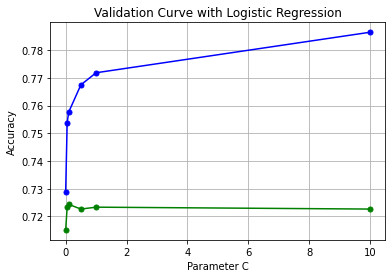

In [118]:
plt.plot(param_range, train_mean,
         marker='o', markersize=5,
         color='blue', label='Training Accuracy')
plt.plot(param_range, test_mean,
         marker='o', markersize=5,
         color='green', label='Validation Accuracy')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Validation Curve with Logistic Regression')
plt.savefig('outputs/figures/' + 'Validation Curve with Logistic Regression',
            dpi=300, bbox_inches='tight')
plt.show()


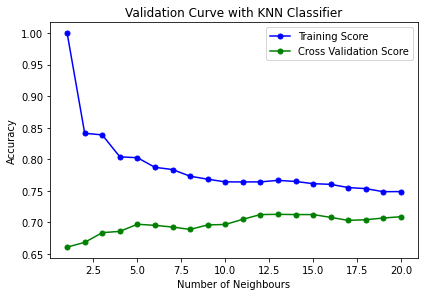

In [133]:
parameter_range = np.arange(1, 21, 1)
train_score, test_score = validation_curve(KNeighborsClassifier(), X_train, y_train,
                                           param_name="n_neighbors",
                                           param_range=parameter_range,
                                           cv=10, scoring="accuracy")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         marker='o', markersize=5,
         color='blue',
         label="Training Score")
plt.plot(parameter_range, mean_test_score,
         label="Cross Validation Score", 
         marker='o', markersize=5,
         color='green')

# Creating the plot
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc='best')
plt.title('Validation Curve with KNN Classifier')
plt.savefig('outputs/figures/' + 'Validation Curve with KNN Classifier',
            dpi=300, bbox_inches='tight')
plt.show()


### Active Learning

In [111]:
X_seed, X_expand, y_seed, y_expand = train_test_split(X_train,
                                                      y_train, test_size=0.8,
                                                      random_state=41,
                                                      stratify=y_train)


In [112]:
print('X_seed: ',len(X_seed))
print('X_expand: ',len(X_expand))

X_seed:  585
X_expand:  2343


### Uncertainty Sampling

In [123]:
def Expand_U(model: fasttext.FastText._FastText,
             algorithm: object,
             seed_set_tokenised: list,
             seed_set_label: list,
             expansion_tokenised: list,
             expansion_set_labels: list,
             batch_size: int,
             countMax: int):
    """ Uncertainty sampling.
    Expand seed set using expansion_set based on lowest confidance scores.
    max_threshold: max. probability for uncertainty selection """

    seed_TK = copy.deepcopy(seed_set_tokenised)
    seed_labels = copy.deepcopy(seed_set_label)
    count = len(expansion_set_labels)
    M = np.arange(0, count, batch_size)

    # exp_TK_certain will be the list of comments having high proba score
    exp_TK_certain = []
    exp_TK_certain_labels = []

    for i in range(1, len(M)):

        #print(M[i], end=' ')

        exp_TK = expansion_tokenised[M[i-1]:M[i]]
        exp_labels = expansion_set_labels[M[i-1]:M[i]]

        # take A as training and B as test and store probs in C
        small_model = algorithm.fit(seed_TK, seed_labels)
        # store classwise prob. scores
        C = small_model.predict_proba(exp_TK)
        # Uncertainty sampling scores
        C_abs_diff = [(abs(x[0] - x[1])) for x in C]

        # Sort lists in ascending order of probabilities from C_abs_diff
        sorted_lists = sorted(
            zip(exp_labels, exp_TK, C, C_abs_diff), key=lambda x: x[3])
        exp_labels, exp_TK, C_sorted, score = [
            [x[i] for x in sorted_lists] for i in range(4)]

        Y_uncertain = []
        exp_TK_uncertain = []
        for j in range(len(C_sorted)):
            max_value = max(C_sorted[j])
            max_index = str(np.argmax(C_sorted[j]))

            # label the comments whose score is less than threshold
            if(j < countMax):

                exp_TK_uncertain.append(exp_TK[j])
                Y_uncertain.append(exp_labels[j])
            else:
                exp_TK_certain.append(exp_TK[j])
                exp_TK_certain_labels.append(exp_labels[j])

        # expand the seed set
        seed_labels.extend(Y_uncertain)
        seed_TK.extend(exp_TK_uncertain)

    return seed_TK, seed_labels, exp_TK_certain, exp_TK_certain_labels


In [124]:

X_uncertain_exp_u, y_uncertain_exp_u, X_certain_exp_u, y_certain_exp_u = Expand_U(model_2,
                                                                                LogisticRegression(),
                                                                                list(
                                                                                    X_seed),
                                                                                list(
                                                                                    y_seed),
                                                                                list(
                                                                                    X_expand),
                                                                                list(
                                                                                    y_expand),
                                                                                20,
                                                                                1
                                                                                )


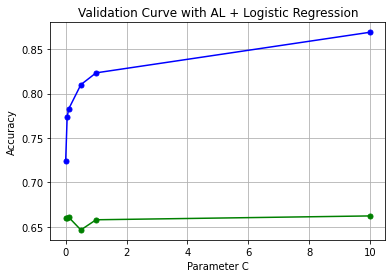

In [125]:
param_range = [0.001, 0.05, 0.1, 0.5, 1.0, 10.0]
train_scores, test_scores = validation_curve(estimator=pipeline,
                                             X=X_uncertain_exp_u, y=y_uncertain_exp_u,
                                             cv=10,
                                             param_name='logisticregression__C', param_range=param_range)
#
# Find the mean of training and test scores out of 10-fod StratifiedKFold cross validation run as part fo execution of validation curve
#
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.plot(param_range, train_mean,
         marker='o', markersize=5,
         color='blue', label='Training Accuracy')
plt.plot(param_range, test_mean,
         marker='o', markersize=5,
         color='green', label='Validation Accuracy')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.grid()
plt.title('Validation Curve with AL + Logistic Regression')
plt.savefig('outputs/figures/' + 'Validation Curve with AL + Logistic Regression',
            dpi=300, bbox_inches='tight')
plt.show()


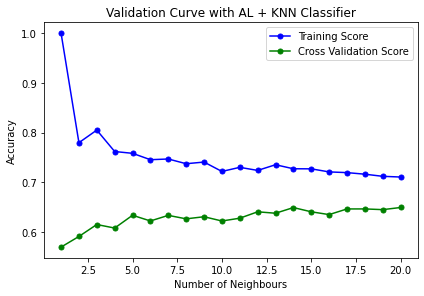

In [132]:
parameter_range = np.arange(1, 21, 1)
train_score, test_score = validation_curve(KNeighborsClassifier(), X_uncertain_exp_u, y_uncertain_exp_u,
                                           param_name="n_neighbors",
                                           param_range=parameter_range,
                                           cv=10, scoring="accuracy")

# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis=1)
std_train_score = np.std(train_score, axis=1)

# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis=1)
std_test_score = np.std(test_score, axis=1)

# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score,
         marker='o', markersize=5,
         color='blue',
         label="Training Score")
plt.plot(parameter_range, mean_test_score,
         label="Cross Validation Score",
         marker='o', markersize=5,
         color='green')

# Creating the plot
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc='best')
plt.title('Validation Curve with AL + KNN Classifier')
plt.savefig('outputs/figures/' + 'Validation Curve with AL + KNN Classifier',
            dpi=300, bbox_inches='tight')
plt.show()
